In [100]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
home_dir = os.path.abspath('..')

In [21]:
def prepare_data(stocks_dir, sentiments_dir, window_size=60):
    stock_files = os.listdir(stocks_dir)
    sentiment_files = os.listdir(sentiments_dir)

    X = []
    y = []

    for f in stock_files:
        if f in sentiment_files:
            stock_df = pd.read_csv(f"{stocks_dir}\\{f}")
            sentiment_df = pd.read_csv(f"{sentiments_dir}\\{f}")

            combined_df = pd.merge(stock_df, sentiment_df, left_on='fdate', right_on='formatted_date', how='outer')

            combined_df['fdate'] = pd.to_datetime(combined_df['fdate'].combine_first(combined_df['formatted_date']))
            combined_df = combined_df.drop(columns=['formatted_date', 'Date', 'Dividends', 'Stock Splits']).dropna()
            combined_df = combined_df.sort_values(by='fdate')

            for i in range(0, (len(combined_df) - window_size - 7), 3):
                # Prepare 60-day stock data
                open_data = combined_df['Open'].values[i:i+60]
                high_data = combined_df['High'].values[i:i+60]
                low_data = combined_df['Low'].values[i:i+60]
                close_data = combined_df['Close'].values[i:i+60]
                volume_data = combined_df['Volume'].values[i:i+60]

                # Prepare 7-day article and sentiment data, padded with 53 zeros on the left
                num_articles_data = np.pad(combined_df['articles'].values[i:i+7], (53, 0), 'constant')
                sentiment_data = np.pad(combined_df['sentiment'].values[i:i+7], (53, 0), 'constant')

                # Stack inputs into the desired shape (60, 5) for stock data and (60, 2) for articles & sentiment
                input_data = [
                    open_data, high_data, low_data, close_data, volume_data, num_articles_data, sentiment_data
                ]
                X.append(np.array(input_data))

                # Output: 7-day future high and low values
                output_high = combined_df['High'].values[i+60:i+67]
                output_low = combined_df['Low'].values[i+60:i+67]
                y.append(np.array([output_high, output_low]))
    
    return np.array(X), np.array(y)

In [22]:
stocks_dir = f"{home_dir}\\data\\processed_data\\stock_data"
sentiments_dir = f"{home_dir}\\data\\processed_data\\sentiment_data"

X, y = prepare_data(stocks_dir, sentiments_dir)

print(X.shape, y.shape)
print(X)
print(y)

(62631, 7, 60) (62631, 2, 7)
[[[ 1.23489968e+02  1.20908573e+02  1.21127003e+02 ...  1.08686933e+02
    1.08975430e+02  1.07542859e+02]
  [ 1.23559466e+02  1.22695696e+02  1.27808840e+02 ...  1.10805952e+02
    1.10020014e+02  1.09343536e+02]
  [ 1.20352584e+02  1.19598019e+02  1.20640511e+02 ...  1.08298943e+02
    1.08617285e+02  1.06846470e+02]
  ...
  [ 2.37610000e+06  1.65500000e+06  2.65470000e+06 ...  2.02890000e+06
    2.36730000e+06  2.88600000e+06]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.00000000e+00
    4.00000000e+00  2.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.00000000e+00
    0.00000000e+00  2.00000000e+00]]

 [[ 1.26389074e+02  1.24542386e+02  1.25823163e+02 ...  1.06945950e+02
    1.02369665e+02  1.02936718e+02]
  [ 1.26448642e+02  1.26260002e+02  1.26974859e+02 ...  1.07503061e+02
    1.03633116e+02  1.04369298e+02]
  [ 1.24075745e+02  1.24184961e+02  1.24800527e+02 ...  1.04816980e+02
    9.95641996e+01  1.02707900e+02]


In [96]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 50104
Validation set size: 6263
Test set size: 6264


In [93]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(14),  # Output layer with 14 neurons
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def load_model(model_path):
    loaded_model = tf.keras.models.load_model(model_path)
    print(f"Model loaded from {model_path}")
    return loaded_model

In [97]:
# Checkpoint system
checkpoint_path = os.path.join(home_dir, "model_checkpoints", "training_1", "cp-{epoch:04d}.weights.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)

os.makedirs(checkpoint_dir, exist_ok=True)

model_directory = os.path.join(home_dir, "saved_models")
model_name = "model_1.h5"

os.makedirs(model_directory, exist_ok=True)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, save_weights_only=True, verbose=1
)

input_shape = (60, 7)
model = create_model(input_shape)

X_train = X_train.reshape(-1, 60, 7)  # Ensure it has the shape (num_samples, 60, 7)
y_train = y_train.reshape(-1, 14)  # Reshape to (num_samples, 14)

X_val = X_val.reshape(-1, 60, 7)
y_val = y_val.reshape(-1, 14)

model.summary()
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print()

# Train the model with the checkpoint callback
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)#, callbacks=[cp_callback])

# model.save(os.path.join(model_directory, model_name))

# Load the model after saving
# loaded_model = load_model(f"{home_dir}\\saved_models\\model_name")  # Uncomment to load the model

c:\Users\Matthew\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                  │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,342 (75.55 KB)

 Trainable params: 19,342 (75.55 KB)

 Non-trainable params: 0 (0.00 B)

<class 'numpy.ndarray'> (50104, 60, 7)
<class 'numpy.ndarray'> (50104, 14)

Epoch 1/10
1561/1566 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 90967.3047
Epoch 1: saving model to c:\Users\Matthew\Desktop\Projects\StockPredictor\model_checkpoints\training_1\cp-0001.weights.h5
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 90928.0312 - val_loss: 47677.5664
Epoch 2/10
1562/1566 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 65612.3125
Epoch 2: saving model to c:\Users\Matthew\Desktop\Projects\StockPredictor\model_checkpoints\training_1\cp-0002.weights.h5
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 65632.5000 - val_loss: 42287.7930
Epoch 3/10
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 60728.2969
Epoch 3: saving model to c:\Users\Matthew\Desktop\Projects\StockPredictor\model_checkpoints\training_1\cp-0003.weights.h5
1566/1566 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 60732.4023 - val_loss: 38714.6641
Epoch 4/10
1563/1566 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 57848.6328
Epoch

In [102]:
def plot_prediction(actual, predicted, title):
    # Split the actual and predicted values into high and low
    actual_high = actual[:7]
    actual_low = actual[7:]
    predicted_high = predicted[:7]
    predicted_low = predicted[7:]
    
    # Create subplots for High and Low
    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot High values
    axs[0].plot(np.arange(len(actual_high)), actual_high, label='Actual High', color='blue', marker='o')
    axs[0].plot(np.arange(len(predicted_high)), predicted_high, label='Predicted High', color='red', marker='x')
    axs[0].set_title('High Values - ' + title)
    axs[0].set_xlabel('Days')
    axs[0].set_ylabel('High Values')
    axs[0].legend()
    axs[0].grid()

    # Plot Low values
    axs[1].plot(np.arange(len(actual_low)), actual_low, label='Actual Low', color='blue', marker='o')
    axs[1].plot(np.arange(len(predicted_low)), predicted_low, label='Predicted Low', color='red', marker='x')
    axs[1].set_title('Low Values - ' + title)
    axs[1].set_xlabel('Days')
    axs[1].set_ylabel('Low Values')
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout()
    plt.show()

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


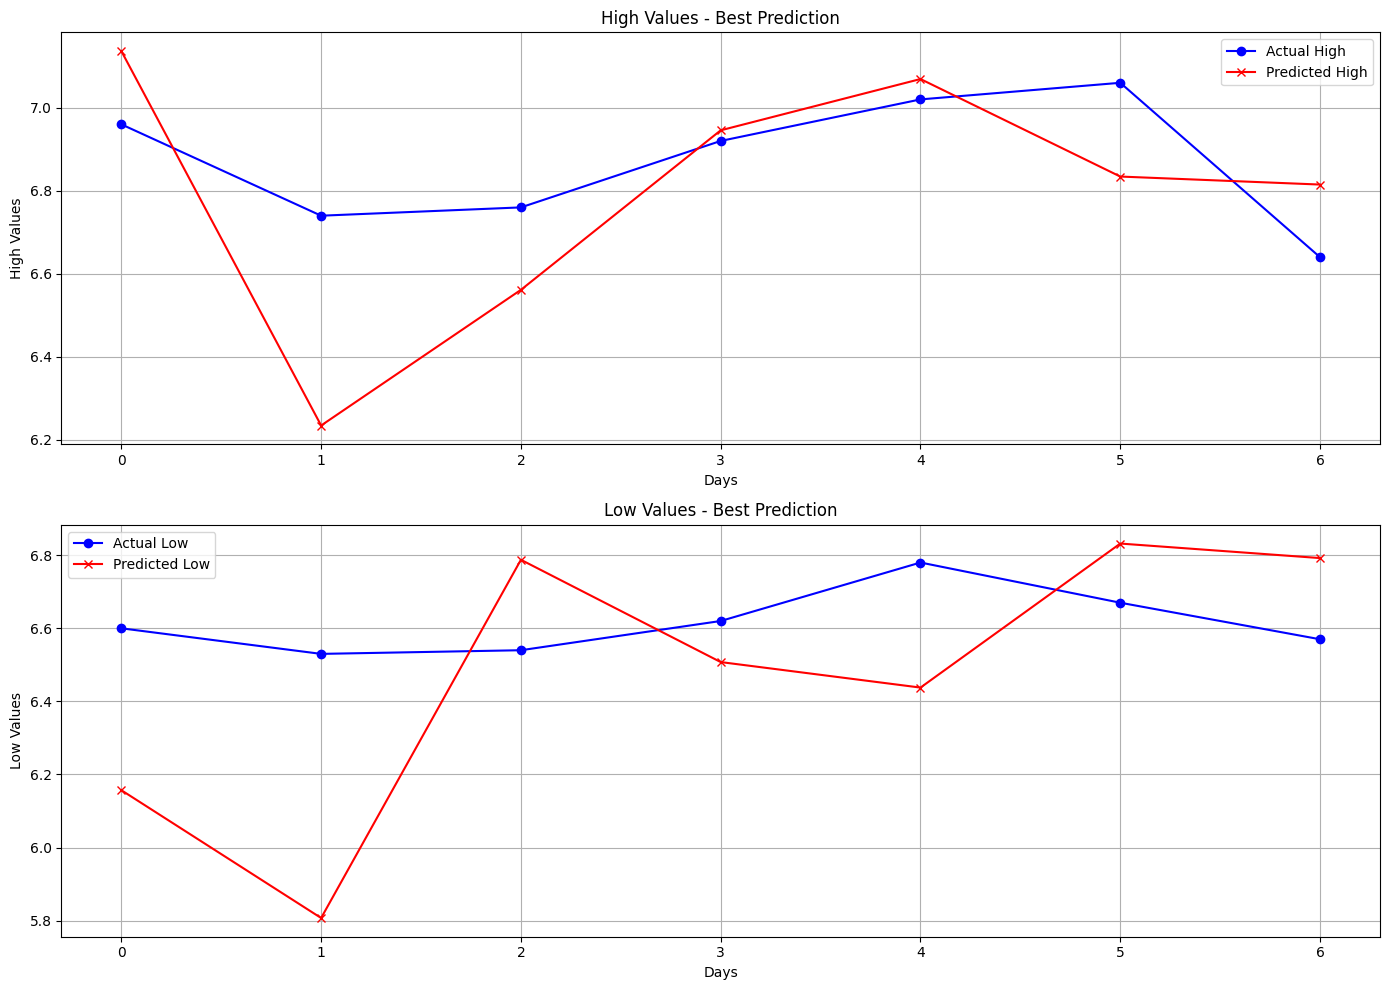

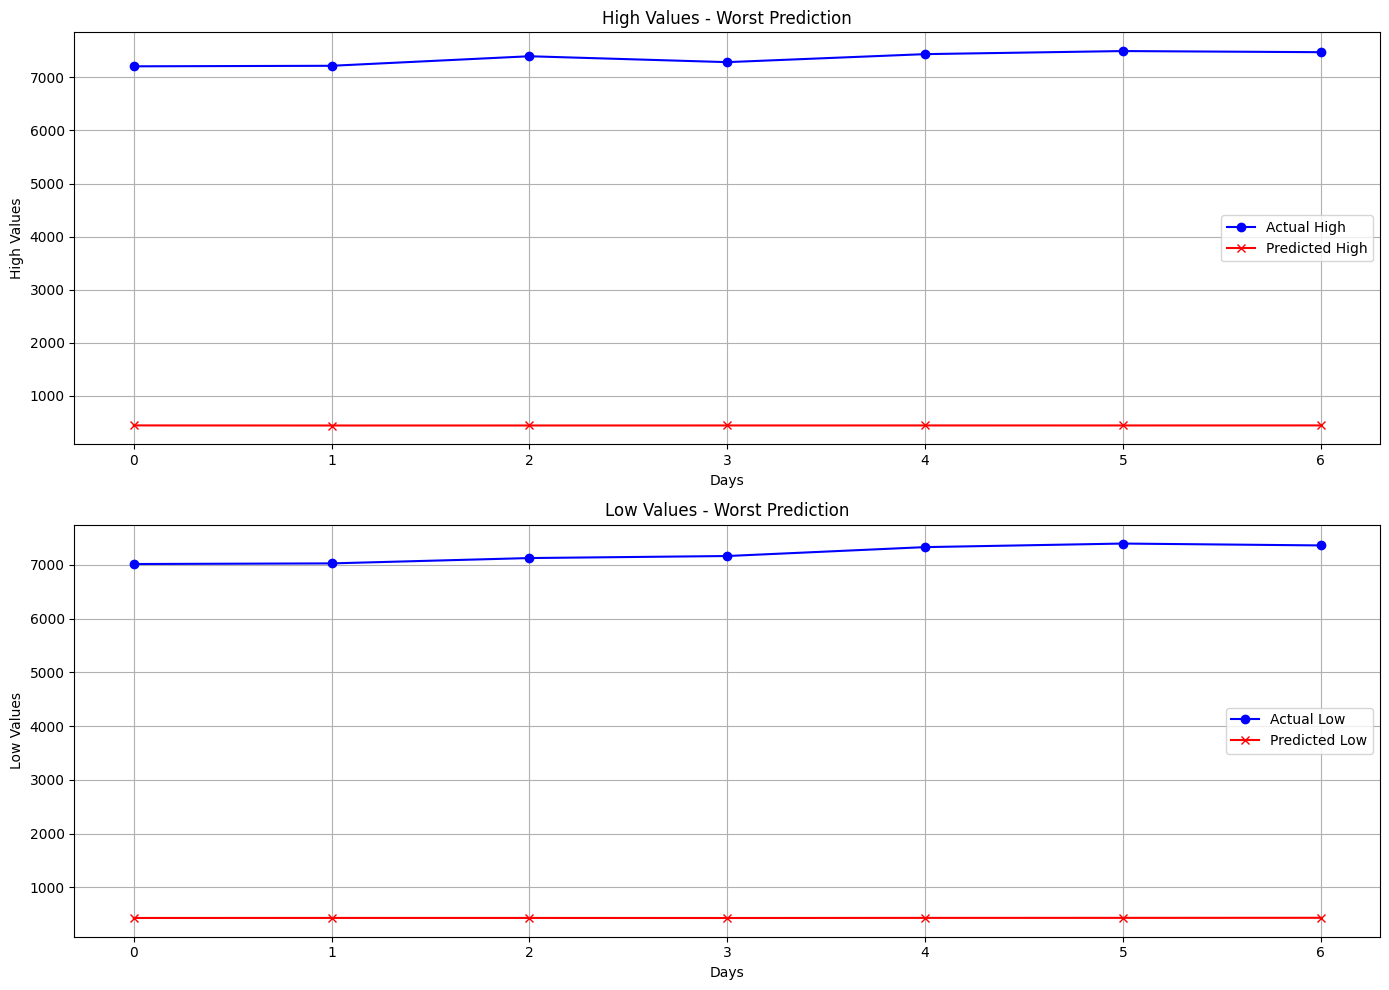

In [103]:
# Step 1: Make predictions on the validation set
predictions = model.predict(X_val)

# Step 2: Calculate errors
predictions_flat = predictions.reshape(-1, 14)
y_val_flat = y_val.reshape(-1, 14)

# Calculate absolute errors
errors = np.abs(predictions_flat - y_val_flat)

# Step 3: Identify the best and worst predictions
best_index = np.argmin(np.sum(errors, axis=1))  # Best prediction (minimum error)
worst_index = np.argmax(np.sum(errors, axis=1))  # Worst prediction (maximum error)

# Plot best prediction
plot_prediction(y_val_flat[best_index], predictions_flat[best_index], 'Best Prediction')

# Plot worst prediction
plot_prediction(y_val_flat[worst_index], predictions_flat[worst_index], 'Worst Prediction')